In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('dataset.csv', on_bad_lines='skip')

In [3]:
data.head()

,Age,Gender,Relationship,Occasion,Budget,MaxBudget,Gift,Rating,Link,Image Link,Interest
0,30,Female,Wife,Anniversery,500,5000,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.5,https://www.amazon.in/dp/B07C8Y15V5/ref=cm_gf_...,https://m.media-amazon.com/images/I/414-x5boCw...,Shopping
1,25,Female,Sister,Birthday,500,10000,AJIO E-Gift Card - Redeemable on AJIO website ...,4.6,https://www.amazon.in/dp/B0B97VTH58/ref=cm_gf_...,https://m.media-amazon.com/images/I/41SR1aKy5Q...,Shopping
2,8,Female,Daughter,Baby & Expecting,1500,2000,ApolloPharmacy FApollo Pharmacy E-Gift Card,4.4,https://www.amazon.in/dp/B086MZN582/ref=cm_gf_...,https://m.media-amazon.com/images/I/41D5brGGcs...,Health
3,29,Female,Sister,Diwali,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.6,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping
4,21,Male,Brother,Birthday,500,2500,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,https://www.amazon.in/dp/B099SRQBNS/ref=cm_gf_...,https://m.media-amazon.com/images/I/51ukgkR7zM...,Sports


## Data Preprocessing

In [4]:
data.isnull().sum()

Age             0
Gender          0
Relationship    0
Occasion        0
Budget          0
MaxBudget       0
Gift            3
Rating          0
Link            3
Image Link      3
Interest        0
dtype: int64

In [5]:
data.dropna(inplace=True)

In [6]:
data.duplicated().sum()

3

In [7]:
data.drop_duplicates(inplace=True)

In [8]:
data.shape

(272, 11)

In [9]:
df = pd.DataFrame(data)
newdf = df.copy()
newdf.shape

(272, 11)

## EDA 

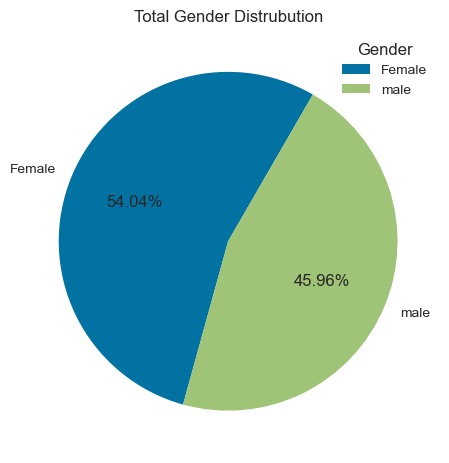

In [10]:
plt.pie(df['Gender'].value_counts(),autopct='%0.2f%%',startangle=60,labels=['Female','male'])
plt.title('Total Gender Distrubution')
plt.legend(title="Gender", loc="best")
plt.show()

#### As we can see here , 

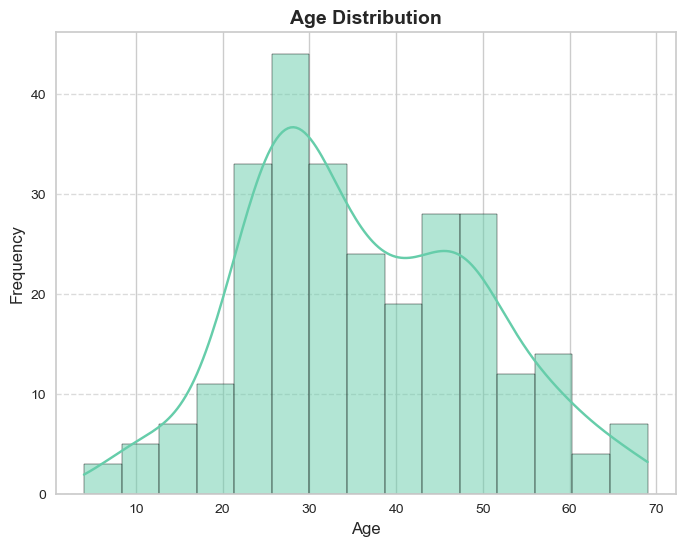

In [11]:
plt.figure(figsize=(8, 6))  
sns.histplot(df['Age'], kde=True, color='#66CDAA', bins=15)
plt.title('Age Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### The age distribution is slightly normal but not perfectly normally distributed.


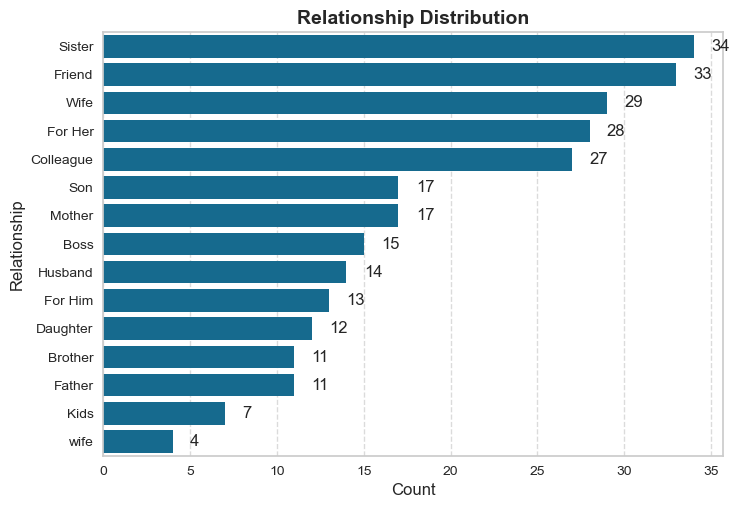

In [12]:
order = df['Relationship'].value_counts().index
sns.countplot(data=df, y='Relationship', order=order)
for index, value in enumerate(df['Relationship'].value_counts()):
    plt.text(value + 1, index, str(value), va='center')
plt.title('Relationship Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Relationship', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### The highest relationships are "Sister" (34) and "Friends" (33). The lowest are "Wife" (4) and "Kids" (7).


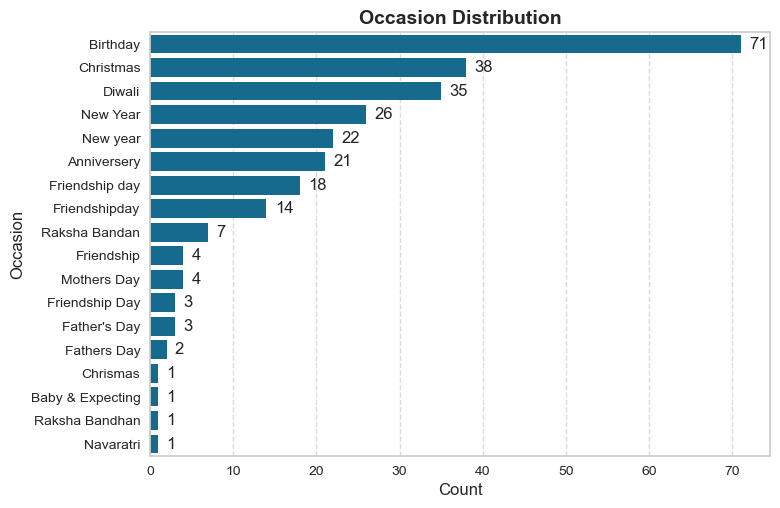

In [13]:
order = df['Occasion'].value_counts().index
sns.countplot(data=df, y='Occasion', order=order)
for index, value in enumerate(df['Occasion'].value_counts()):
    plt.text(value + 1, index, str(value), va='center')
plt.title('Occasion Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Occasion', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
plt.show()

#### The most frequent occasion is "Birthday" (74).


#### This project uses an **unsupervised learning algorithm** where outliers do not significantly impact the results.
#### Outliers can be ignored during EDA and analysis as they are not relevant for clustering-based models.

## Text preparation 

In [14]:
def getMappingDictionary(unique_data):
    mappingDictionary = {}
    for i in range(len(unique_data)):
        mappingDictionary[unique_data[i]] = i
    return mappingDictionary

#### Creates a mapping dictionary for categorical columns by assigning unique integer values to each unique category in the column.

In [15]:
def getUniqueDataList(columnName):
    return list(set(data[columnName]))

#### Extracts a list of unique values from a specific column in the dataset.

In [16]:
def modifyDatasetColumn(columnName, mapping_dict):
    data[columnName] = data[columnName].map(mapping_dict)

#### Modifies a specific column in the dataset by replacing its categorical values with their corresponding numerical values using a mapping dictionary.

In [17]:
def modifyDataset(columnName):
    unique_columnValues = getUniqueDataList(columnName)
    print(unique_columnValues)
    mapping_dict = getMappingDictionary(unique_columnValues)
    print(mapping_dict)
    modifyDatasetColumn(columnName,mapping_dict)

#### Applies the modifyDatasetColumn function to multiple columns in the dataset, ensuring all specified columns are converted from categorical to numerical using their respective mapping dictionaries.

In [18]:
modifyDataset('Gender')
data.head()

['Female', 'Male']
{'Female': 0, 'Male': 1}


,Age,Gender,Relationship,Occasion,Budget,MaxBudget,Gift,Rating,Link,Image Link,Interest
0,30,0,Wife,Anniversery,500,5000,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.5,https://www.amazon.in/dp/B07C8Y15V5/ref=cm_gf_...,https://m.media-amazon.com/images/I/414-x5boCw...,Shopping
1,25,0,Sister,Birthday,500,10000,AJIO E-Gift Card - Redeemable on AJIO website ...,4.6,https://www.amazon.in/dp/B0B97VTH58/ref=cm_gf_...,https://m.media-amazon.com/images/I/41SR1aKy5Q...,Shopping
2,8,0,Daughter,Baby & Expecting,1500,2000,ApolloPharmacy FApollo Pharmacy E-Gift Card,4.4,https://www.amazon.in/dp/B086MZN582/ref=cm_gf_...,https://m.media-amazon.com/images/I/41D5brGGcs...,Health
3,29,0,Sister,Diwali,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.6,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping
4,21,1,Brother,Birthday,500,2500,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,https://www.amazon.in/dp/B099SRQBNS/ref=cm_gf_...,https://m.media-amazon.com/images/I/51ukgkR7zM...,Sports


In [19]:
modifyDataset('Relationship')
data.head()

['For Her', 'Colleague', 'Brother', 'For Him', 'Wife', 'Mother', 'Father', 'Son', 'Kids', 'Friend', 'Husband', 'Daughter', 'wife', 'Sister', 'Boss']
{'For Her': 0, 'Colleague': 1, 'Brother': 2, 'For Him': 3, 'Wife': 4, 'Mother': 5, 'Father': 6, 'Son': 7, 'Kids': 8, 'Friend': 9, 'Husband': 10, 'Daughter': 11, 'wife': 12, 'Sister': 13, 'Boss': 14}


,Age,Gender,Relationship,Occasion,Budget,MaxBudget,Gift,Rating,Link,Image Link,Interest
0,30,0,4,Anniversery,500,5000,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.5,https://www.amazon.in/dp/B07C8Y15V5/ref=cm_gf_...,https://m.media-amazon.com/images/I/414-x5boCw...,Shopping
1,25,0,13,Birthday,500,10000,AJIO E-Gift Card - Redeemable on AJIO website ...,4.6,https://www.amazon.in/dp/B0B97VTH58/ref=cm_gf_...,https://m.media-amazon.com/images/I/41SR1aKy5Q...,Shopping
2,8,0,11,Baby & Expecting,1500,2000,ApolloPharmacy FApollo Pharmacy E-Gift Card,4.4,https://www.amazon.in/dp/B086MZN582/ref=cm_gf_...,https://m.media-amazon.com/images/I/41D5brGGcs...,Health
3,29,0,13,Diwali,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.6,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping
4,21,1,2,Birthday,500,2500,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,https://www.amazon.in/dp/B099SRQBNS/ref=cm_gf_...,https://m.media-amazon.com/images/I/51ukgkR7zM...,Sports


In [20]:
modifyDataset('Occasion')
data.head()

['New year', 'Friendship', 'Raksha Bandan', 'Fathers Day', 'Birthday', 'Friendship Day', 'Diwali', 'Christmas', 'New Year', 'Navaratri', "Father's Day", 'Friendship day', 'Chrismas', 'Friendshipday', 'Baby & Expecting', 'Raksha Bandhan', 'Mothers Day', 'Anniversery']
{'New year': 0, 'Friendship': 1, 'Raksha Bandan': 2, 'Fathers Day': 3, 'Birthday': 4, 'Friendship Day': 5, 'Diwali': 6, 'Christmas': 7, 'New Year': 8, 'Navaratri': 9, "Father's Day": 10, 'Friendship day': 11, 'Chrismas': 12, 'Friendshipday': 13, 'Baby & Expecting': 14, 'Raksha Bandhan': 15, 'Mothers Day': 16, 'Anniversery': 17}


,Age,Gender,Relationship,Occasion,Budget,MaxBudget,Gift,Rating,Link,Image Link,Interest
0,30,0,4,17,500,5000,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.5,https://www.amazon.in/dp/B07C8Y15V5/ref=cm_gf_...,https://m.media-amazon.com/images/I/414-x5boCw...,Shopping
1,25,0,13,4,500,10000,AJIO E-Gift Card - Redeemable on AJIO website ...,4.6,https://www.amazon.in/dp/B0B97VTH58/ref=cm_gf_...,https://m.media-amazon.com/images/I/41SR1aKy5Q...,Shopping
2,8,0,11,14,1500,2000,ApolloPharmacy FApollo Pharmacy E-Gift Card,4.4,https://www.amazon.in/dp/B086MZN582/ref=cm_gf_...,https://m.media-amazon.com/images/I/41D5brGGcs...,Health
3,29,0,13,6,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.6,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping
4,21,1,2,4,500,2500,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,https://www.amazon.in/dp/B099SRQBNS/ref=cm_gf_...,https://m.media-amazon.com/images/I/51ukgkR7zM...,Sports


In [21]:
modifyDataset('Interest')
data.head()

['Fashion', 'Art', 'Technology', 'Health', 'Shopping', 'Music', 'Food', 'Travel', 'Entertainment', 'Movies', 'Sports']
{'Fashion': 0, 'Art': 1, 'Technology': 2, 'Health': 3, 'Shopping': 4, 'Music': 5, 'Food': 6, 'Travel': 7, 'Entertainment': 8, 'Movies': 9, 'Sports': 10}


,Age,Gender,Relationship,Occasion,Budget,MaxBudget,Gift,Rating,Link,Image Link,Interest
0,30,0,4,17,500,5000,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.5,https://www.amazon.in/dp/B07C8Y15V5/ref=cm_gf_...,https://m.media-amazon.com/images/I/414-x5boCw...,4
1,25,0,13,4,500,10000,AJIO E-Gift Card - Redeemable on AJIO website ...,4.6,https://www.amazon.in/dp/B0B97VTH58/ref=cm_gf_...,https://m.media-amazon.com/images/I/41SR1aKy5Q...,4
2,8,0,11,14,1500,2000,ApolloPharmacy FApollo Pharmacy E-Gift Card,4.4,https://www.amazon.in/dp/B086MZN582/ref=cm_gf_...,https://m.media-amazon.com/images/I/41D5brGGcs...,3
3,29,0,13,6,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.6,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,4
4,21,1,2,4,500,2500,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,https://www.amazon.in/dp/B099SRQBNS/ref=cm_gf_...,https://m.media-amazon.com/images/I/51ukgkR7zM...,10


In [22]:
dataframe_headers = data.columns.values
dataframe_headers

array(['Age', 'Gender', 'Relationship', 'Occasion', 'Budget', 'MaxBudget',
       'Gift', 'Rating', 'Link', 'Image Link', 'Interest'], dtype=object)

In [23]:
data.drop(['Relationship','Occasion','Budget','MaxBudget','Gift','Rating','Link','Image Link'],axis=1, inplace=True)
data

,Age,Gender,Interest
0,30,0,4
1,25,0,4
2,8,0,3
3,29,0,4
4,21,1,10
...,...,...,...
270,54,0,6
271,60,1,6
272,36,1,6
273,37,0,6


In [24]:
new_headers = data.columns.values
new_headers

array(['Age', 'Gender', 'Interest'], dtype=object)

## Model Buliding

### 1st model = The goal of clustering is to group similar data points together based on their features. In this step, we use an unsupervised learning algorithm like K-Means to identify patterns in the dataset and divide it into distinct clusters.

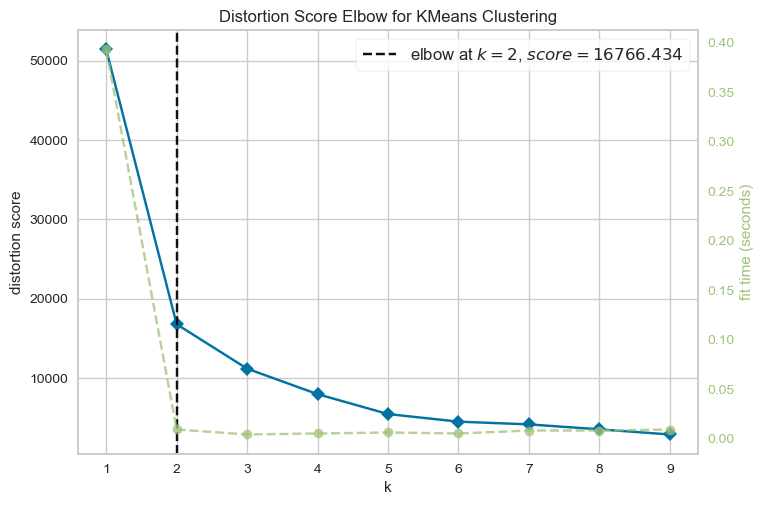

In [25]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10)) 
visualizer.fit(data)
visualizer.show()
k= visualizer.elbow_value_

In [40]:
kmeans = KMeans(n_clusters = 3, init='k-means++', random_state= 42)  
customer_segments = kmeans.fit_predict(data)
customer_segments

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0,
       1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 1, 2, 2,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1,
       0, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1,
       1, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2,
       0, 2, 0, 2, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2,
       0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1,
       2, 0, 2, 2, 2, 0, 0, 2])

In [41]:
input_customer_data = {
       'Age': [40], 
       'Gender': [2], 
       'Interest': [1],
}

new_customer = pd.DataFrame(input_customer_data)
new_customer_segment = kmeans.predict(new_customer[new_headers])
new_customer_segment[0]
print('New customer belongs to segment:', new_customer_segment[0])

New customer belongs to segment: 0


In [28]:
kmeans.labels_

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0,
       1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 1, 2, 2,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1,
       0, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1,
       1, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2,
       0, 2, 0, 2, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2,
       0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1,
       2, 0, 2, 2, 2, 0, 0, 2])

In [29]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
df2 = pd.DataFrame()
df2.index.name = 'id'
df2['Relationship']= newdf.iloc[:,2]
df2['Ocassion']= newdf.iloc[:,3]
df2['Budget']= newdf.iloc[:,5]
df2['Interest']= newdf.iloc[:,10]
df2['Gift']= newdf.iloc[:,6]
df2['Rating']= newdf.iloc[:,7]
df2['Cluster']= customer_segments
df2

,Relationship,Ocassion,Budget,Interest,Gift,Rating,Cluster
id,,,,,,,
0,Wife,Anniversery,5000,Shopping,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.5,0
1,Sister,Birthday,10000,Shopping,AJIO E-Gift Card - Redeemable on AJIO website ...,4.6,1
2,Daughter,Baby & Expecting,2000,Health,ApolloPharmacy FApollo Pharmacy E-Gift Card,4.4,1
3,Sister,Diwali,10000,Shopping,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.6,0
4,Brother,Birthday,2500,Sports,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,1
...,...,...,...,...,...,...,...
270,Colleague,Friendship day,3000,Food,Swiggy Digital Gift Card,4.3,2
271,Colleague,Friendship day,3000,Food,Swiggy Digital Gift Card,4.3,2
272,Friend,Friendship day,3000,Food,Faasos Restaurant Digital Gift Card,4.3,0


In [30]:
Newdata = pd.DataFrame()
Newdata=df2[df2['Cluster'] == new_customer_segment[0]]
Newdata 

,Relationship,Ocassion,Budget,Interest,Gift,Rating,Cluster
id,,,,,,,
0,Wife,Anniversery,5000,Shopping,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.5,0
3,Sister,Diwali,10000,Shopping,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.6,0
5,Father,Birthday,2500,Sports,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,0
8,Mother,Birthday,2500,Sports,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,0
9,Mother,Mothers Day,2500,Sports,Decathlon Omni Flat 3% off at checkout E-Gift ...,4.6,0
...,...,...,...,...,...,...,...
263,Son,Birthday,8000,Food,BARBEQUE NATION Digital Gift Card,4.3,0
265,Friend,Birthday,3000,Food,Swiggy Digital Gift Card,4.3,0
268,For Her,Birthday,3000,Food,Cafe Coffee Day Digital Gift Card,4.3,0


In [31]:
recommended_products = Newdata[Newdata['Rating'] >= 3]
recommended_products = recommended_products[recommended_products['Relationship'] == 'Wife']

In [32]:
recommended_products = recommended_products[recommended_products['Ocassion'] == 'Anniversery']
recommended_products = recommended_products.sort_values(by=['Rating'],ascending=False)
recommended_products

,Relationship,Ocassion,Budget,Interest,Gift,Rating,Cluster
id,,,,,,,
21,Wife,Anniversery,10000,Fashion,Joyalukkas Gold E-Gift Card - Flat 2% off - Re...,4.700000,0
0,Wife,Anniversery,5000,Shopping,BigBasket E-Gift Card - Flat 2% off - Redeemab...,4.500000,0
201,Wife,Anniversery,3000,Travel,ITC Hotels Digital Gift Card,4.300000,0
120,Wife,Anniversery,10000,Sports,Health & Glow E-Gift Card,3.866667,0
126,Wife,Anniversery,10000,Fashion,Bodycraft - Digital Voucher,3.866667,0
129,Wife,Anniversery,15000,Health,wakefit Digital Gift Card,3.866667,0


#### 2nd model = After identifying the cluster relevant to the user, cosine similarity is used to recommend the most suitable gifts. This similarity measure calculates how closely related two vectors (gift and user preferences) are, based on the angle between them.

In [33]:
df['Combined'] = df['Gift'] + " " + df['Occasion'].astype(str) + " " + df['Interest'].astype(str)
vectorizer = TfidfVectorizer()
gift_vectors = vectorizer.fit_transform(df['Combined'])

In [34]:
similarity_matrix = cosine_similarity(gift_vectors)

In [35]:
similarity_matrix = cosine_similarity(gift_vectors)

In [36]:
selected_gift_index = 0
similar_gifts = list(enumerate(similarity_matrix[selected_gift_index]))
similar_gifts = sorted(similar_gifts, key=lambda x: x[1], reverse=True)
top_5_gifts = [df.iloc[i[0]] for i in similar_gifts[1:6]]

In [37]:
top_5_gifts_df = pd.DataFrame(top_5_gifts)
top_5_gifts_df

,Age,Gender,Relationship,Occasion,Budget,MaxBudget,Gift,Rating,Link,Image Link,Interest,Combined
151,14,Female,Sister,Anniversery,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.600000,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping,Myntra E-Gift Card - Flat 5% off - Redeemable ...
145,29,Female,Sister,Christmas,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.600000,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping,Myntra E-Gift Card - Flat 5% off - Redeemable ...
3,29,Female,Sister,Diwali,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.600000,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping,Myntra E-Gift Card - Flat 5% off - Redeemable ...
147,49,Female,Sister,Friendship,100,10000,Myntra E-Gift Card - Flat 5% off - Redeemable ...,4.600000,https://www.amazon.in/dp/B0B46K5TP2/ref=cm_gf_...,https://m.media-amazon.com/images/I/41ivYwRqny...,Shopping,Myntra E-Gift Card - Flat 5% off - Redeemable ...
106,34,Male,Husband,Anniversery,500,10000,Vistara E-Gift Card - Flat 7% off - Redeemable...,3.866667,https://www.amazon.in/dp/B09PCJHMQT/ref=cm_gf_...,https://m.media-amazon.com/images/I/41O40KujAx...,Travel,Vistara E-Gift Card - Flat 7% off - Redeemable...
